In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def read_data(init):
    """
    Reads and concatenates parquet files containing forecast and error data for GFS, NAM, and HRRR weather models
    for the years 2018 to 2021, with random forecasts that have a forecast hour of 0 removed.

    Args:
        init (str): A string representing the initial time of the forecast (in UTC).

    Returns:
        tuple of pandas.DataFrame: A tuple containing three dataframes, one for each weather model, with random
        forecasts that have a forecast hour of 0 removed.
    """
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    # create empty lists to hold dataframes for each model
    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    # concatenate dataframes for each model
    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # remove random forecasts that have forecast hours 0 for each model
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]

    # return dataframes for each model
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

### Next steps include:
* Training on more than 1 year of data.
* Trying out different variables
* Predicting ONE forecast time, not an entire year's worth

In [3]:
init = "12"

gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    init
)

hrrr = hrrr_fcast_and_error_df.copy()

In [4]:
hrrr_2018 = hrrr.query("time > 2017 and time < 2019")
hrrr_2019 = hrrr.query("time > 2018 and time < 2020")

In [5]:
hrrr_2018 = hrrr_2018.drop(columns=["latitude", "longitude"])
hrrr_2019 = hrrr_2019.drop(columns=["latitude", "longitude"])

In [6]:
hrrr_2018.keys()

Index(['t2m_HRRR', 'd2m_HRRR', 'u_total_HRRR', 'u_dir_HRRR', 'new_tp_HRRR',
       'mslma_HRRR', 'orog', 't2m_error', 'd2m_error', 'u_total_error',
       'u_dir_error', 'new_tp_error', 'mslma_error', 't2m_nysm', 'd2m_nysm',
       'u_total_nysm', 'u_dir_nysm', 'new_tp_nysm', 'mslma_nysm',
       'lead_time_DAY', 'lead_time_HOUR', 'lead_time_ONLY_HOURS'],
      dtype='object')

In [7]:
# given the forecast & error statistics for the HRRR above, can we train a model
# to output what the observation will actually be based on the error column?
# or output the likelihood of that forecast verifying against the NYSM observations?

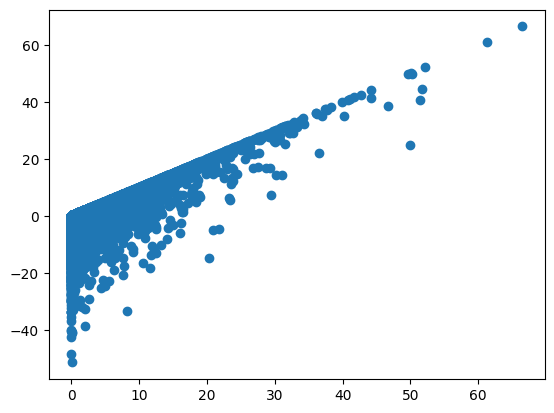

In [9]:
plt.scatter(hrrr_2018["new_tp_HRRR"], hrrr_2018["new_tp_error"])
# plt.xlim(-30,30)
# plt.ylim(-20,20)

In [10]:
hrrr[hrrr.isnull().any(axis=1)]

,,,t2m_HRRR,d2m_HRRR,u_total_HRRR,u_dir_HRRR,latitude,longitude,new_tp_HRRR,mslma_HRRR,orog,t2m_error,...,mslma_error,t2m_nysm,d2m_nysm,u_total_nysm,u_dir_nysm,new_tp_nysm,mslma_nysm,lead_time_DAY,lead_time_HOUR,lead_time_ONLY_HOURS
station,valid_time,time,,,,,,,,,,,,,,,,,,,,,


In [11]:
# train a decision tree:
# Predictor: HRRR forecast at one location (2-m temperature, total precipitation, etc)
# Predictand: Forecast error

loc = "VOOR"
x_cols = hrrr_2018.keys()[0:6].tolist()
print(x_cols)

X = hrrr.loc[loc][x_cols].values
Y = hrrr.loc[loc]["d2m_error"].values
regr = tree.DecisionTreeRegressor(max_depth=8, random_state=1234)
regr = regr.fit(X, Y)

['t2m_HRRR', 'd2m_HRRR', 'u_total_HRRR', 'u_dir_HRRR', 'new_tp_HRRR', 'mslma_HRRR']


In [12]:
X_test_2019 = hrrr_2019.loc[loc][x_cols].values
Y_preds = regr.predict(X_test_2019)
Y_test_2019 = hrrr_2019.loc[loc]["d2m_error"].values

print(
    "Test Accuracy : %.3f" % regr.score(X_test_2019, Y_test_2019)
)  ## Score method also evaluates accuracy for classification models.
print("Training Accuracy : %.3f" % regr.score(X, Y))

Test Accuracy : 0.436
Training Accuracy : 0.457


In [13]:
# now train a random forest

x_cols = hrrr_2018.keys()[0:6].tolist()

X = hrrr_2018.loc[loc][x_cols].values
Y = hrrr_2018.loc[loc]["d2m_error"].values

rf = RandomForestRegressor(
    max_depth=8, n_estimators=100, min_samples_leaf=1, random_state=1234
)
rf.fit(X, Y)

RandomForestRegressor(max_depth=8, random_state=1234)

In [14]:
print(
    "Test Accuracy : %.3f" % rf.score(X_test_2019, Y_test_2019)
)  ## Score method also evaluates accuracy for classification models.
print("Training Accuracy : %.3f" % rf.score(X, Y))

Test Accuracy : 0.277
Training Accuracy : 0.506


In [15]:
y_1 = rf.predict(X_test_2019)

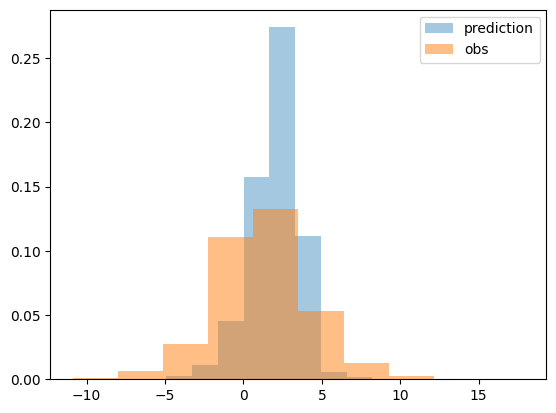

In [16]:
plt.hist(y_1, density=True, alpha=0.4, label="prediction")
plt.hist(Y_test_2019, density=True, alpha=0.5, label="obs")
plt.legend(loc=0)